In [13]:
import lal
import pycbc
import bilby
import pickle
import pycbc.psd
import pycbc.types
import pycbc.waveform
import pycbc.detector
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import lalsimulation
from pycbc.frame import write_frame
from mpl_toolkits.axes_grid1 import make_axes_locatable
from pycbc.waveform.utils import taper_timeseries

plt.style.use('default')
plt.rcParams.update({"text.usetex": True,
    "font.family": "sans-serif",
    "axes.formatter.use_mathtext": True})

# Setting some constants

delta_f = 1/8
duration = 8
minimum_frequency = 20
reference_frequency = 50   # Most sensitive frequency
maximum_frequency = 1024
sampling_frequency = 2048
N_iter = int(12)   # Number of iterations of the initial points

In [2]:

# Generate BBH Injections (SINGLES/ PAIRS) and inject into detectors (H1, L1, V1) 

def wf_len_mod_start(wf, extra=1, **prms):
    """
    [Inherited from GWMAT.] 
        Function to modify the starting of a WF so that it starts on an integer GPS time (in sec) + add extra length as specified by the user.
    """      

    olen = len(wf)   
    diff = wf.sample_times[0]-np.floor(wf.sample_times[0])  
    #nlen = round(olen+sampling_frequency*(extra+diff))
    dlen = round(sampling_frequency*(extra+diff))
    wf_strain = np.concatenate((np.zeros(dlen), wf))
    t0 = wf.sample_times[0]
    dt = wf.delta_t
    n = dlen
    tnn = t0-(n+1)*dt
    wf_stime = np.concatenate((np.arange(t0-dt,tnn,-dt)[::-1], np.array(wf.sample_times)))
    nwf = pycbc.types.TimeSeries(wf_strain, delta_t=wf.delta_t, epoch=wf_stime[0])
    
    return nwf

def wf_len_mod_end(wf, extra=2, **prms): #post_trig_duration
    """
    [Inherited from GWMAT.]
        Function to modify the end of a WF so that it ends on an integer GPS time (in sec) + add extra length as specified by the user.
    """        

    olen = len(wf)   
    dt = abs(wf.sample_times[-1] - wf.sample_times[-2])
    diff = np.ceil(wf.sample_times[-1]) - (wf.sample_times[-1] + dt)   #wf.sample_times[-1]-int(wf.sample_times[-1])  
    nlen = round(olen + sampling_frequency*(extra+diff))
    wf.resize(nlen)
    
    return wf    

def make_len_power_of_2(wf):
    """
    [Inherited from GWMAT.] 
        Function to modify the length of a waveform so that its duration is a power of 2.
    """    

    dur = wf.duration  
    wf.resize( int(round(wf.sample_rate * np.power(2, np.ceil( np.log2( dur ) ) ))) )
    wf = cyclic_time_shift_of_WF(wf, rwrap = wf.duration - dur )
    
    return wf

def cyclic_time_shift_of_WF(wf, rwrap=0.2):
    """
    [Inherited from GWMAT.] 
        Inspired by PyCBC's function pycbc.types.TimeSeries.cyclic_time_shift(), 
        it shifts the data and timestamps in the time domain by a given number of seconds (rwrap). 
        Difference between this and PyCBCs function is that this function preserves the sample rate of the WFs while cyclically rotating, 
        but the time shift cannot be smaller than the intrinsic sample rate of the data, unlike PyCBc's function.
        To just change the time stamps, do ts.start_time += dt.
        Note that data will be cyclically rotated, so if you shift by 2
        seconds, the final 2 seconds of your data will now be at the
        beginning of the data set.
    """        

    # This function does cyclic time shift of a WF.
    # It is similar to PYCBC's "cyclic_time_shift" except for the fact that it also preserves the Sample Rate of the original WF.
    if rwrap is not None and rwrap != 0:
        sn = abs(int(rwrap/wf.delta_t))     # number of elements to be shifted 
        cycles = int(sn/len(wf))

        cyclic_shifted_wf = wf.copy()

        sn_new = sn - int(cycles * len(wf))

        if rwrap > 0:
            epoch = wf.sample_times[0] - sn_new * wf.delta_t
            if sn_new != 0:
                wf_arr = np.array(wf).copy()
                tmp_wf_p1 = wf_arr[-sn_new:]
                tmp_wf_p2 = wf_arr[:-sn_new] 
                shft_wf_arr = np.concatenate(( tmp_wf_p1, tmp_wf_p2 ))
                cyclic_shifted_wf = pycbc.types.TimeSeries(shft_wf_arr, delta_t = wf.delta_t, epoch = epoch)
        else:
            epoch = wf.sample_times[sn_new]
            if sn_new != 0:
                wf_arr = np.array(wf).copy()
                tmp_wf_p1 = wf_arr[sn_new:] 
                tmp_wf_p2 = wf_arr[:sn_new]
                shft_wf_arr = np.concatenate(( tmp_wf_p1, tmp_wf_p2 ))
                cyclic_shifted_wf = pycbc.types.TimeSeries(shft_wf_arr, delta_t = wf.delta_t, epoch = epoch)  

        for i in range(cycles):        
                epoch = epoch - np.sign(rwrap)*wf.duration
                wf_arr = np.array(cyclic_shifted_wf)[:]
                cyclic_shifted_wf = pycbc.types.TimeSeries(wf_arr, delta_t = wf.delta_t, epoch = epoch)

        assert len(cyclic_shifted_wf) == len(wf), 'Length mismatch: cyclic time shift added extra length to WF.'
        return cyclic_shifted_wf
    else:
        return wf  

def jframe_to_l0frame(mass_1, mass_2, f_ref, phi_ref=0., theta_jn=0., phi_jl=0., a_1=0., a_2=0., tilt_1=0., tilt_2=0., phi_12=0., **kwargs):  
    """
    [Inherited from PyCBC and lalsimulation.]
        Function to convert J-frame coordinates (which Bilby uses for PE) to L0-frame coordinates (that Pycbc uses for waveform generation).
        J stands for the total angular momentum while L0 stands for the orbital angular momentum.
    """ 

    inclination, spin1x, spin1y, spin1z, spin2x, spin2y, spin2z = \
        lalsimulation.SimInspiralTransformPrecessingNewInitialConditions(
            theta_jn, phi_jl, tilt_1, tilt_2, phi_12,
            a_1, a_2, mass_1*lal.MSUN_SI, mass_2*lal.MSUN_SI, f_ref,
            phi_ref)
    out_dict = {'inclination': inclination,
                'spin1x': spin1x,
                'spin1y': spin1y,
                'spin1z': spin1z,
                'spin2x': spin2x,
                'spin2y': spin2y,
                'spin2z': spin2z}
    return out_dict

def interp(wf, low_frequency_cutoff, high_frequency_cutoff, delta_f):
    """
    [Inherited from GWMAT.] 
        Interpolate the waveform to the respective frequencies.
    """

    frequency_series = np.arange(low_frequency_cutoff, high_frequency_cutoff, delta_f)
    wf_arr =  np.log10(np.array(wf, dtype=np.complex128))

    interpfn = sp.interpolate.interp1d(wf.sample_frequencies[:], wf_arr[:], kind='linear')

    wf_interpolated = np.concatenate(([0], 10**interpfn(frequency_series[1:])))
    wf_interpolated *= (frequency_series >= low_frequency_cutoff) * (frequency_series <= high_frequency_cutoff)

    return wf_interpolated

def inject_singles_pycbc(injection_parameters):
    """
    Generate PyCBC time domain SINGLES waveforms for the injection parameters, and returns injection projections of a signal onto the Hanford, Livingston, Virgo detectors
    """

    lframe = jframe_to_l0frame(mass_1=injection_parameters['mass_1'], 
                               mass_2=injection_parameters['mass_2'], 
                               f_ref=reference_frequency, 
                               theta_jn=injection_parameters['theta_jn'], 
                               phi_jl=injection_parameters['phi_jl'], 
                               a_1=injection_parameters['a_1'], 
                               a_2=injection_parameters['a_2'], 
                               tilt_1=injection_parameters['tilt_1'], 
                               tilt_2=injection_parameters['tilt_2'], 
                               phi_12=injection_parameters['phi_12'])    

    waveform_params = {
        'approximant': 'IMRPhenomXPHM',
        'mass1': injection_parameters['mass_1'],
        'mass2': injection_parameters['mass_2'],
        'spin1x': lframe['spin1x'],
        'spin1y': lframe['spin1y'],
        'spin1z': lframe['spin1z'],
        'spin2x': lframe['spin2x'],
        'spin2y': lframe['spin2y'],
        'spin2z': lframe['spin2z'],
        'distance': injection_parameters['luminosity_distance'],
        'inclination': lframe['inclination'],
        'coa_phase': injection_parameters['phase'],
        'f_lower': minimum_frequency,
        'f_ref': reference_frequency,
        'delta_t': 1 / sampling_frequency
    }

    hp, hc = pycbc.waveform.get_td_waveform(**waveform_params)
    hp.start_time += injection_parameters['geocent_time']
    hc.start_time += injection_parameters['geocent_time']

    det, ifo_signal = dict(), dict()
    for ifo in ['H1', 'L1', 'V1']:
        det[ifo] = pycbc.detector.Detector(ifo)
        ifo_signal[ifo] = det[ifo].project_wave(hp, hc, injection_parameters['ra'], injection_parameters['dec'], injection_parameters['psi'])
        ifo_signal[ifo] = taper_timeseries(ifo_signal[ifo], tapermethod='TAPER_STARTEND', return_lal=False)
        ifo_signal[ifo] = make_len_power_of_2(wf_len_mod_end(wf_len_mod_start(ifo_signal[ifo])))

    ht_H1, ht_L1, ht_V1 = ifo_signal['H1'], ifo_signal['L1'], ifo_signal['V1']

    return ht_H1, ht_L1, ht_V1

def inject_pairs_pycbc(injection_parameters_a, injection_parameters_b):
    """
    Generate PyCBC time domain PAIRS waveforms for the injection parameters, and returns injection projections of a signal onto the Hanford, Livingston, Virgo detectors
    """

    lframe_a = jframe_to_l0frame(mass_1=injection_parameters_a['mass_1'], 
                                 mass_2=injection_parameters_a['mass_2'], 
                                 f_ref=reference_frequency, 
                                 theta_jn=injection_parameters_a['theta_jn'], 
                                 phi_jl=injection_parameters_a['phi_jl'], 
                                 a_1=injection_parameters_a['a_1'], 
                                 a_2=injection_parameters_a['a_2'], 
                                 tilt_1=injection_parameters_a['tilt_1'], 
                                 tilt_2=injection_parameters_a['tilt_2'], 
                                 phi_12=injection_parameters_a['phi_12'])   

    waveform_params_a = {
        'approximant': 'IMRPhenomXPHM',
        'mass1': injection_parameters_a['mass_1'],
        'mass2': injection_parameters_a['mass_2'],
        'spin1x': lframe_a['spin1x'],
        'spin1y': lframe_a['spin1y'],
        'spin1z': lframe_a['spin1z'],
        'spin2x': lframe_a['spin2x'],
        'spin2y': lframe_a['spin2y'],
        'spin2z': lframe_a['spin2z'],
        'distance': injection_parameters_a['luminosity_distance'],
        'inclination': lframe_a['inclination'],
        'coa_phase': injection_parameters_a['phase'],
        'f_lower': minimum_frequency,
        'f_ref': reference_frequency,
        'delta_t': 1 / sampling_frequency
    }

    lframe_b = jframe_to_l0frame(mass_1=injection_parameters_b['mass_1'],
                                 mass_2=injection_parameters_b['mass_2'],
                                 f_ref=reference_frequency,
                                 theta_jn=injection_parameters_b['theta_jn'],
                                 phi_jl=injection_parameters_b['phi_jl'],
                                 a_1=injection_parameters_b['a_1'],
                                 a_2=injection_parameters_b['a_2'],
                                 tilt_1=injection_parameters_b['tilt_1'],
                                 tilt_2=injection_parameters_b['tilt_2'],
                                 phi_12=injection_parameters_b['phi_12'])

    waveform_params_b = {
        'approximant': 'IMRPhenomXPHM',
        'mass1': injection_parameters_b['mass_1'],
        'mass2': injection_parameters_b['mass_2'],
        'spin1x': lframe_b['spin1x'],
        'spin1y': lframe_b['spin1y'],
        'spin1z': lframe_b['spin1z'],
        'spin2x': lframe_b['spin2x'],
        'spin2y': lframe_b['spin2y'],
        'spin2z': lframe_b['spin2z'],
        'distance': injection_parameters_b['luminosity_distance'],
        'inclination': lframe_b['inclination'],
        'coa_phase': injection_parameters_b['phase'],
        'f_lower': minimum_frequency,
        'f_ref': reference_frequency,
        'delta_t': 1 / sampling_frequency
    }

    det, ifo_signal_a, ifo_signal_b = dict(), dict(), dict()

    for ifo in ['H1', 'L1', 'V1']:
        det[ifo] = pycbc.detector.Detector(ifo)

        hp_a, hc_a = pycbc.waveform.get_td_waveform(**waveform_params_a)
        hp_a.start_time += injection_parameters_a['geocent_time']
        hc_a.start_time += injection_parameters_a['geocent_time']

        ifo_signal_a[ifo] = det[ifo].project_wave(hp_a, hc_a, injection_parameters_a['ra'], injection_parameters_a['dec'], injection_parameters_a['psi'])
        ifo_signal_a[ifo] = taper_timeseries(ifo_signal_a[ifo], tapermethod='TAPER_STARTEND', return_lal=False)
        ifo_signal_a[ifo] = make_len_power_of_2(wf_len_mod_end(wf_len_mod_start(ifo_signal_a[ifo])))
        
        hp_b, hc_b = pycbc.waveform.get_td_waveform(**waveform_params_b)
        hp_b.start_time += injection_parameters_b['geocent_time']
        hc_b.start_time += injection_parameters_b['geocent_time']

        ifo_signal_b[ifo] = det[ifo].project_wave(hp_b, hc_b, injection_parameters_b['ra'], injection_parameters_b['dec'], injection_parameters_b['psi'])
        ifo_signal_b[ifo] = taper_timeseries(ifo_signal_b[ifo], tapermethod='TAPER_STARTEND', return_lal=False)
        ifo_signal_b[ifo] = make_len_power_of_2(wf_len_mod_end(wf_len_mod_start(ifo_signal_b[ifo])))

    ht_H1_a, ht_L1_a, ht_V1_a = ifo_signal_a['H1'], ifo_signal_a['L1'], ifo_signal_a['V1']
    ht_H1_b, ht_L1_b, ht_V1_b = ifo_signal_b['H1'], ifo_signal_b['L1'], ifo_signal_b['V1']

    hf_a_H1, hf_a_L1, hf_a_V1 = ht_H1_a.to_frequencyseries(), ht_L1_a.to_frequencyseries(), ht_V1_a.to_frequencyseries()
    hf_b_H1, hf_b_L1, hf_b_V1 = ht_H1_b.to_frequencyseries(), ht_L1_b.to_frequencyseries(), ht_V1_b.to_frequencyseries()

    hf_a_H1, hf_a_L1, hf_a_V1 = interp(hf_a_H1, minimum_frequency, maximum_frequency, delta_f), interp(hf_a_L1, minimum_frequency, maximum_frequency, delta_f), interp(hf_a_V1, minimum_frequency, maximum_frequency, delta_f)
    hf_b_H1, hf_b_L1, hf_b_V1 = interp(hf_b_H1, minimum_frequency, maximum_frequency, delta_f), interp(hf_b_L1, minimum_frequency, maximum_frequency, delta_f), interp(hf_b_V1, minimum_frequency, maximum_frequency, delta_f)

    hf_a_H1, hf_a_L1, hf_a_V1 = pycbc.types.frequencyseries.FrequencySeries(hf_a_H1, delta_f),  pycbc.types.frequencyseries.FrequencySeries(hf_a_L1, delta_f),  pycbc.types.frequencyseries.FrequencySeries(hf_a_V1, delta_f)
    hf_b_H1, hf_b_L1, hf_b_V1 = pycbc.types.frequencyseries.FrequencySeries(hf_b_H1, delta_f),  pycbc.types.frequencyseries.FrequencySeries(hf_b_L1, delta_f),  pycbc.types.frequencyseries.FrequencySeries(hf_b_V1, delta_f)

    hf_H1 = hf_a_H1 + hf_b_H1 * np.exp(-1j * 2 * np.pi * (injection_parameters_b['geocent_time'] - injection_parameters_a['geocent_time']) * hf_b_L1.sample_frequencies)
    hf_L1 = hf_a_L1 + hf_b_L1 * np.exp(-1j * 2 * np.pi * (injection_parameters_b['geocent_time'] - injection_parameters_a['geocent_time']) * hf_b_L1.sample_frequencies)
    hf_V1 = hf_a_V1 + hf_b_V1 * np.exp(-1j * 2 * np.pi * (injection_parameters_b['geocent_time'] - injection_parameters_a['geocent_time']) * hf_b_V1.sample_frequencies)

    ht_H1, ht_L1, ht_V1 = hf_H1.to_timeseries(), hf_L1.to_timeseries(), hf_V1.to_timeseries()
    
    return ht_H1, ht_L1, ht_V1

# Generating SINGLES A & B

injection_parameters_a = {'mass_1': 20, 
                        'mass_2': 40, 
                        'luminosity_distance': 800, 
                        'a_1': 0, 
                        'a_2': 0, 
                        'tilt_1': 0, 
                        'tilt_2': 0, 
                        'theta_jn': 0, 
                        'phi_12': 1.3264568220000164, 
                        'phi_jl': 4.3767796519003026, 
                        'ra': -0.2231247386804483, 
                        'dec': 0.1839772515975745, 
                        'psi': 1.649825290199503, 
                        'phase': 1.3371755312430611, 
                        'incl': 1.4430344336874731, 
                        'geocent_time': 1126259462.4702857}

injection_parameters_b = {'mass_1': 30, 
                        'mass_2': 30, 
                        'luminosity_distance': 650, 
                        'a_1': 0, 
                        'a_2': 0, 
                        'tilt_1': 0, 
                        'tilt_2': 0, 
                        'theta_jn': 0, 
                        'phi_12': 2.3264568220000164, 
                        'phi_jl': 2.3767796519003026, 
                        'ra': 0.8231247386804483, 
                        'dec': -0.7839772515975745, 
                        'psi': 2.649825290199503, 
                        'phase': 0.3371755312430611, 
                        'incl': 0.4430344336874731, 
                        'geocent_time': 1126259462.4702857+0.1}

# Generating SINGLES

ht_a_H1, ht_a_L1, ht_a_V1 = inject_singles_pycbc(injection_parameters_a)

ht_b_H1, ht_b_L1, ht_b_V1 = inject_singles_pycbc(injection_parameters_b)

# Generating PAIRS

ht_H1, ht_L1, ht_V1 = inject_pairs_pycbc(injection_parameters_a, injection_parameters_b)

In [8]:
def mconv(mchirp, eta):
    """
    Calculates the masses given the chirp mass and symmetric mass ratio.
    """
    
    mtotal = mchirp * np.power(eta, -3/5)
    mass_1 = mtotal*(1+np.sqrt(1-4*eta))/2
    mass_2 = mtotal*(1-np.sqrt(1-4*eta))/2 

    return mass_1, mass_2

def inject_wf(injection_parameters):
    """
    Generate time domain waveforms for the injection parameters, and returns injection projections of a signal onto the Hanford, Livingston, Virgo detectors
    """

    waveform_generator = bilby.gw.WaveformGenerator(duration = duration, sampling_frequency = sampling_frequency, start_time = injection_parameters['geocent_time']-duration+2,
                                                    frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole, 
                                                    waveform_arguments = {'waveform_approximant': 'IMRPhenomXPHM', 'reference_frequency': reference_frequency, 'minimum_frequency': minimum_frequency})

    ifos = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])   # Initializing the Detectors

    for ifo in ifos:
        ifo.minimum_frequency, ifo.maximum_frequency = minimum_frequency, sampling_frequency/2
    ifos.set_strain_data_from_zero_noise(sampling_frequency = sampling_frequency, duration = duration, start_time = injection_parameters['geocent_time']-duration+2)

    # Injecting the SINGLES GW signal into H1, L1, and V1 using bilby and extrapolating the strain data in the time domain

    ifos.inject_signal(waveform_generator = waveform_generator, parameters = injection_parameters, raise_error=False)  
    H1_strain, L1_strain, V1_strain = ifos[0].time_domain_strain, ifos[1].time_domain_strain, ifos[2].time_domain_strain

    # Generating PyCBC TimeSeries from the strain array, setting the start times to the geocenter time, and creating the dictionary of waveforms 

    ht_H1, ht_L1, ht_V1 = pycbc.types.TimeSeries(H1_strain, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(L1_strain, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(V1_strain, delta_t = 1/sampling_frequency)
    ht_H1.start_time, ht_L1.start_time, ht_V1.start_time = injection_parameters['geocent_time']-duration+2, injection_parameters['geocent_time']-duration+2, injection_parameters['geocent_time']-duration+2
    ht = {'H1': ht_H1, 'L1': ht_L1, 'V1': ht_V1}

    return ht

def inject_pairs(injection_parameters_a, injection_parameters_b):
    """
    Generate time domain PAIRS waveforms for the injection parameters, and returns injection projections of a signal onto the Hanford, Livingston, Virgo detectors
    """

    waveform_generator_a = bilby.gw.WaveformGenerator(duration = duration, sampling_frequency = sampling_frequency, start_time = injection_parameters_a['geocent_time']-duration+2,
                                                     frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole, 
                                                     waveform_arguments = {'waveform_approximant': 'IMRPhenomXPHM', 'reference_frequency': reference_frequency, 'minimum_frequency': minimum_frequency})

    waveform_generator_b = bilby.gw.WaveformGenerator(duration = duration, sampling_frequency = sampling_frequency, start_time = injection_parameters_a['geocent_time']-duration+2,
                                                     frequency_domain_source_model=bilby.gw.source.lal_binary_black_hole, 
                                                     waveform_arguments = {'waveform_approximant': 'IMRPhenomXPHM', 'reference_frequency': reference_frequency, 'minimum_frequency': minimum_frequency})

    ifos = bilby.gw.detector.InterferometerList(['H1', 'L1', 'V1'])   # Initializing the Detectors

    for ifo in ifos:
        ifo.minimum_frequency, ifo.maximum_frequency = minimum_frequency, sampling_frequency/2
    ifos.set_strain_data_from_zero_noise(sampling_frequency = sampling_frequency, duration = duration, start_time = injection_parameters_a['geocent_time']-duration+2)

    # Injecting the SINGLES GW signal into H1, L1, and V1 using bilby and extrapolating the strain data in the time domain

    ifos.inject_signal(waveform_generator = waveform_generator_a, parameters = injection_parameters_a)    # PAIRS (A)
    ifos.inject_signal(waveform_generator = waveform_generator_b, parameters = injection_parameters_b)    # PAIRS (B)

    H1_strain, L1_strain, V1_strain = ifos[0].time_domain_strain, ifos[1].time_domain_strain, ifos[2].time_domain_strain

    # Generating PyCBC TimeSeries from the strain array, setting the start times to the geocenter time, and creating the dictionary of waveforms 

    ht_H1, ht_L1, ht_V1 = pycbc.types.TimeSeries(H1_strain, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(L1_strain, delta_t = 1/sampling_frequency), pycbc.types.TimeSeries(V1_strain, delta_t = 1/sampling_frequency)
    ht_H1.start_time, ht_L1.start_time, ht_V1.start_time = injection_parameters_a['geocent_time']-duration+2, injection_parameters_a['geocent_time']-duration+2, injection_parameters_a['geocent_time']-duration+2
    ht = {'H1': ht_H1, 'L1': ht_L1, 'V1': ht_V1}

    return ht

def read_psd(det, flen, low_frequency_cutoff=minimum_frequency, delta_f=delta_f):
    """
    Reading the PSD files for the detectors
    """

    if det == 'H1':
        psd = pycbc.psd.read.from_txt('../../psds/psd_aLIGO_O4high.txt', flen, delta_f, low_frequency_cutoff, is_asd_file=False)
    if det == 'L1':
        psd = pycbc.psd.read.from_txt('../../psds/psd_aLIGO_O4high.txt', flen, delta_f, low_frequency_cutoff, is_asd_file=False)
    if det == 'V1':
        psd = pycbc.psd.read.from_txt('../../psds/psd_aVirgo_O4high_NEW.txt', flen, delta_f, low_frequency_cutoff, is_asd_file=False)

    for i in range(len(psd)):
        if psd[i]==0:
            psd[i]=1e-52 

    return psd

In [4]:
h, h_templ = inject_wf(injection_parameters_a)['H1'], inject_wf(injection_parameters_b)['H1']
hf, hf_templ = h.to_frequencyseries(), h_templ.to_frequencyseries()

13:56 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters
13:56 bilby INFO    : Injected signal in H1:
13:56 bilby INFO    :   optimal SNR = 30.99
13:56 bilby INFO    :   matched filter SNR = 30.99+0.00j
13:56 bilby INFO    :   mass_1 = 20
13:56 bilby INFO    :   mass_2 = 40
13:56 bilby INFO    :   luminosity_distance = 800
13:56 bilby INFO    :   a_1 = 0
13:56 bilby INFO    :   a_2 = 0
13:56 bilby INFO    :   tilt_1 = 0
13:56 bilby INFO    :   tilt_2 = 0
13:56 bilby INFO    :   theta_jn = 0
13:56 bilby INFO    :   phi_12 = 1.3264568220000164
13:56 bilby INFO    :   phi_jl = 4.376779651900303
13:56 bilby INFO    :   ra = -0.2231247386804483
13:56 bilby INFO    :   dec = 0.1839772515975745
13:56 bilby INFO    :   psi = 1.649825290199503
13:56 bilby INFO    :   phase = 1.337175531243061
13:56 bilby IN

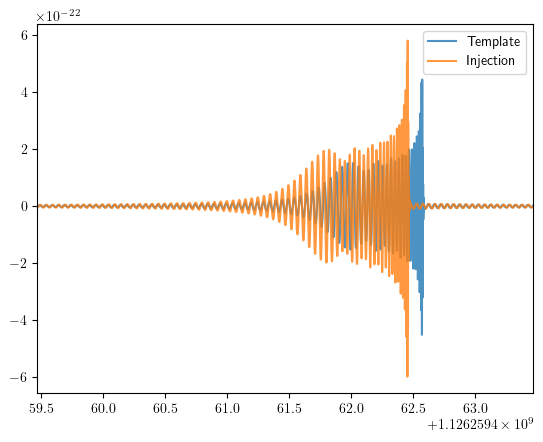

In [14]:
plt.plot(h_templ.sample_times, h_templ, label = 'Template', alpha=0.8)
plt.plot(h.sample_times, h, label = 'Injection', alpha=0.8)
plt.xlim(injection_parameters_a['geocent_time']-3, injection_parameters_a['geocent_time']+1)
plt.legend()
plt.show()
plt.close()

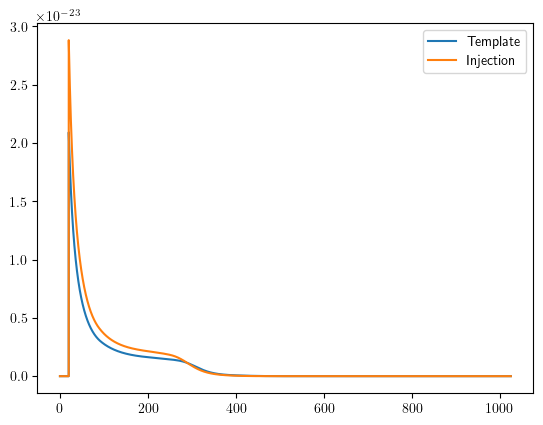

In [15]:
plt.plot(hf_templ.sample_frequencies, np.abs(hf_templ), label = 'Template')
plt.plot(hf.sample_frequencies, np.abs(hf), label = 'Injection')
plt.legend()
plt.show()
plt.close()

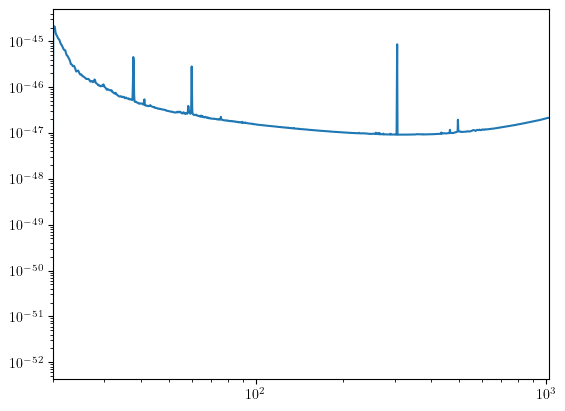

In [16]:
psd = read_psd('H1', max(len(h), len(h_templ))//2+1)
plt.loglog(psd.sample_frequencies, np.abs(psd))
plt.xlim(minimum_frequency, maximum_frequency)
plt.show()
plt.close()

### Match Function

In [18]:
def inner(h1, h2, psd=None, df=delta_f):
    """
    [Inherited from gwtools.]
        Real part of the frequency domain weighted complex inner product.
    """

    if psd is None:
        return np.real(4 * df * h2.dot(np.conjugate(h1)))
        
    return np.real(4 * df * h2.dot(np.conjugate(h1)/psd))

def inner_complex_timeshift_series(h1, h2, psd=None):
    """
    [Inherited from gwtools.]
        Uses an inverse fft to compute inner_complex of h1 and
        h2*exp(2*pi*i*f*dt) for dt=0, 1/f_max, 2/f_max, ...
    """

    if psd is None:
        return np.fft.fft(np.conjugate(h1)*h2)
    
    return np.fft.fft(np.conjugate(h1)*h2/psd)

def _cyclic_quadratic_peak(y):
    """
    [Inherited from gwtools.]
        Finds the peak value of y using a quadratic curve through the max
        value and its neighbors. Assumes periodic boundary conditions if the max
        is at the edge.
        Returns i_peak (float), y_peak.                 
    """

    n, idx = len(y), np.argmax(y)
    y0 = y[idx]
    rp1 = y[(idx+1)%n] - y0
    rm1 = y[(idx-1)%n] - y0
    b = 0.5*(rp1 - rm1)
    c = 0.5*(rp1 + rm1)
    if c==0.:
        print('Warning: no quadratic term present in time optimization, using argmax')
        return idx, y0
    y_peak = y0 - 0.25*b*b/c
    i_peak = idx - 0.5*b/c
    return i_peak, y_peak

def mismatch(h1, h2, psd=None, df=delta_f):
    """
    [Inherited from gwtools.]
        Minimizes the overlap error over time shifts
    """

    n1, n2 = inner(h1, h1, psd), inner(h2, h2, psd)
    d = inner_complex_timeshift_series(h1, h2, psd)
    i_max, d_max = _cyclic_quadratic_peak(np.real(d))  

    return 1 - d_max/np.sqrt(n1*n2)

In [ ]:
h.resize(max(len(h), len(h_templ)))
h_templ.resize(max(len(h), len(h_templ)))

hf, hf_templ = h.to_frequencyseries(), h_templ.to_frequencyseries()

In [19]:
1-mismatch(hf, hf, psd=psd)

2.0000000000000027

### Alternative

In [20]:
def interp(wf, low_frequency_cutoff, high_frequency_cutoff, delta_f):
    """Taken from GWMAT. Interpolate the waveform to the respective frequencies."""

    frequency_series = np.arange(low_frequency_cutoff, high_frequency_cutoff, delta_f)
    wf_arr =  np.log10(np.array(wf, dtype=np.complex128))

    interpfn = sp.interpolate.interp1d(wf.sample_frequencies[:], wf_arr[:], kind='linear')

    wf_interpolated = np.concatenate(([0], 10**interpfn(frequency_series[1:])))
    wf_interpolated *= (frequency_series >= low_frequency_cutoff) * (frequency_series <= high_frequency_cutoff)

    return wf_interpolated, frequency_series

In [21]:
def inner(wf1, wf2, low_frequency_cutoff, high_frequency_cutoff, psd=None):
    """ Return the inner product of the two FrequencySeries with complex conjugation."""

    delta_f = min(wf1.delta_f, wf2.delta_f)

    wf1, _ = interp(wf1, low_frequency_cutoff, high_frequency_cutoff, delta_f)
    wf2, _ = interp(wf2, low_frequency_cutoff, high_frequency_cutoff, delta_f)

    if psd is None:
        dot = np.vdot(wf1, wf2)
    else:
        dot = np.vdot(np.divide(wf1, psd), wf2)

    inner = 4 * np.real(dot) * delta_f

    return inner

In [22]:
def overlap(wf1, wf2, low_frequency_cutoff, high_frequency_cutoff, psd):
    """ Returns overlap of the two FrequencySeries"""

    inner_prod = inner(wf1, wf2, low_frequency_cutoff, high_frequency_cutoff, psd)
    sigma1 = inner(wf1, wf1, low_frequency_cutoff, high_frequency_cutoff, psd)
    sigma2 = inner(wf2, wf2, low_frequency_cutoff, high_frequency_cutoff, psd)

    overlap = inner_prod / np.sqrt(sigma1) / np.sqrt(sigma2)

    return overlap

In [23]:
def mis_overlap(time, wf1, wf2, low_frequency_cutoff, high_frequency_cutoff, psd):
    """ Returns 1-overlap of the two FrequencySeries at given difference time"""

    wf2_shift = wf2 * np.exp(2j*np.pi*time*wf2.sample_frequencies)
    
    return np.log10(1-overlap(wf1, wf2_shift, low_frequency_cutoff, high_frequency_cutoff, psd))

In [24]:
def max_overlap(wf1, wf2, low_frequency_cutoff, high_frequency_cutoff, psd):
    """ Returns maximum overlap = match, maximised over time domain"""
    
    function_overlap = lambda x : mis_overlap(x, wf1, wf2, low_frequency_cutoff, high_frequency_cutoff, psd)
    mismatch = sp.optimize.minimize(function_overlap, 0, method='nelder-mead', options={'xatol': 1e-12, 'adaptive': True}) 

    return 1-10**mismatch.fun, mismatch.x

In [25]:
h, h_templ = ht_b_H1, ht_a_H1 
hf, hf_templ = h.to_frequencyseries(), h_templ.to_frequencyseries()

hf_templ_shift = hf_templ * np.exp(-2j*np.pi*1*hf_templ.sample_frequencies)
h_templ_shift = hf_templ_shift.to_timeseries()
h_templ = h_templ_shift

hf, hf_templ = h.to_frequencyseries(), h_templ.to_frequencyseries()

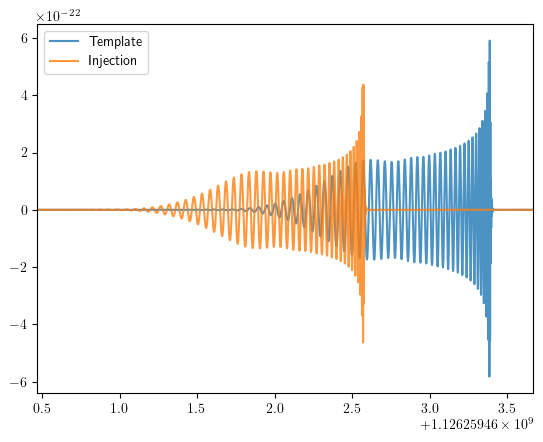

In [37]:
plt.plot(h_templ.sample_times, h_templ, label = 'Template', alpha=0.8)
plt.plot(h.sample_times, h, label = 'Injection', alpha=0.8)
plt.xlim(injection_parameters_a['geocent_time']-2, injection_parameters_a['geocent_time']+1.2)
plt.legend()
plt.show()
plt.close()

In [40]:
m_overlap = max_overlap(hf, hf_templ, minimum_frequency, maximum_frequency, psd=None)
m_overlap

(0.015642247364815787, array([0.01781557]))

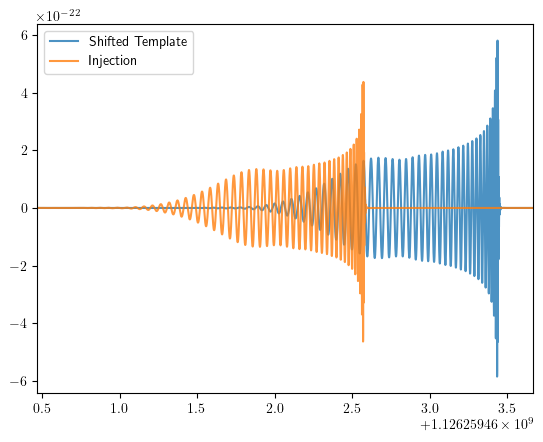

In [38]:
hf_templ_shift = hf_templ * np.exp(2j*np.pi*m_overlap[1]*hf_templ.sample_frequencies)
h_templ_shift = hf_templ_shift.to_timeseries()

plt.plot(h_templ_shift.sample_times, h_templ_shift, label = 'Shifted Template', alpha=0.8)
plt.plot(h.sample_times, h, label = 'Injection', alpha=0.8)
plt.xlim(injection_parameters_a['geocent_time']-2, injection_parameters_a['geocent_time']+1.2)
plt.legend()
plt.show()
plt.close()

In [29]:
times = np.arange(-.1, .1, 0.001)
op = np.zeros(len(times))
wf1, wf2 = hf, hf_templ 
for i, time in enumerate(times):
    wf2_shift = wf2 * np.exp(2j*np.pi*time*wf2.sample_frequencies)
    op[i] = overlap(wf1, wf2_shift, minimum_frequency, maximum_frequency, psd=None)

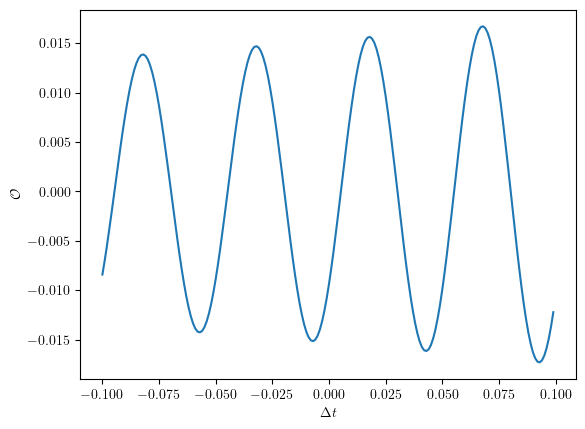

In [30]:
plt.plot(times, op)
plt.xlabel('$\\Delta t$')
plt.ylabel('$\\mathcal{O}$')
plt.show()

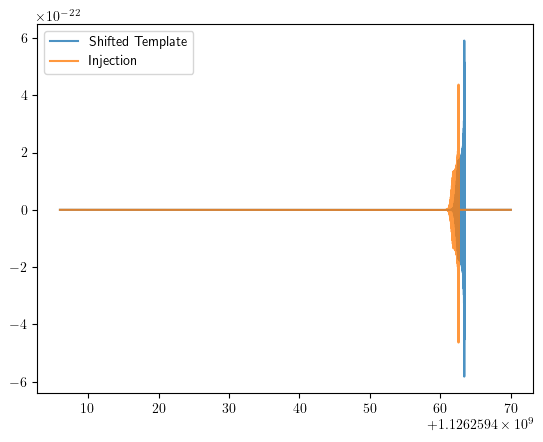

In [32]:
hf_templ_shift = hf_templ * np.exp(2j*np.pi*times[np.argmax(op)]*hf_templ.sample_frequencies)
h_templ_shift = hf_templ_shift.to_timeseries()
h_templ = h_templ_shift

plt.plot(h_templ.sample_times, h_templ, label = 'Shifted Template', alpha=0.8)
plt.plot(h.sample_times, h, label = 'Injection', alpha=0.8)
plt.legend()
plt.show()
plt.close()